# 岭回归和 LASSO 回归实现
## 普通最小二乘法的局限性
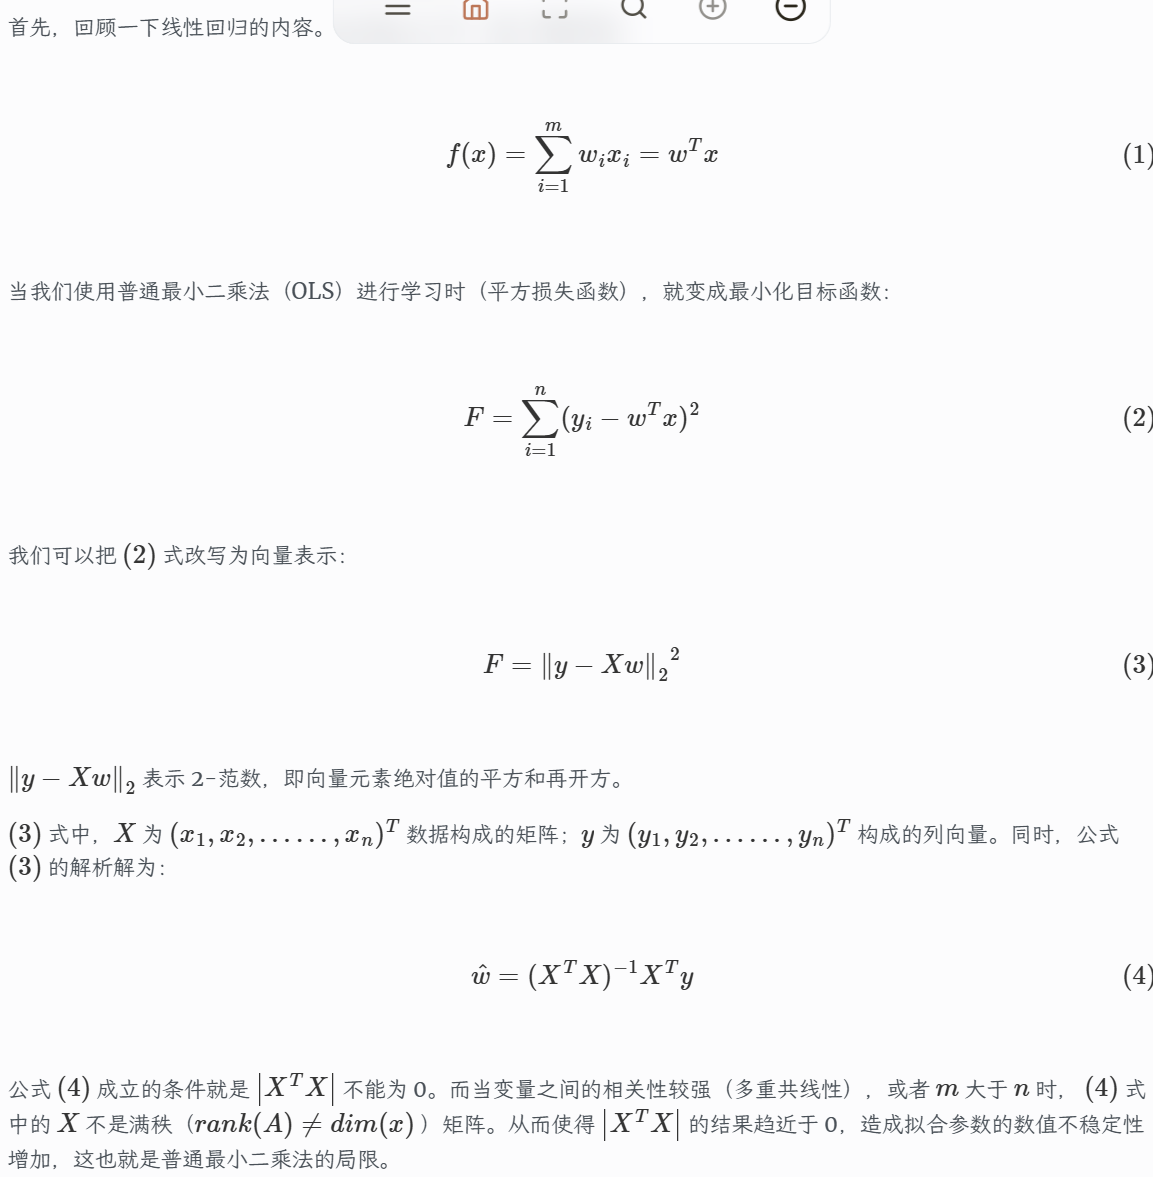

## 希尔伯特矩阵OLS线性拟合
线性代数中，希尔伯特矩阵是一种系数都是单位分数的方块矩阵。具体来说一个希尔伯特矩阵$H$的第$i$横行第$j$纵列的系数是：
$$
H_{ij} = \frac{1}{i+j-1}
$$
一个$5 * 5$的希尔伯特矩阵如下所示：
$$
H_5 = \begin{bmatrix}
1 & \frac{1}{2} & \frac{1}{3} & \frac{1}{4} & \frac{1}{5} \\
\frac{1}{2} & \frac{1}{3} & \frac{1}{4} & \frac{1}{5} & \frac{1}{6} \\
\frac{1}{3} & \frac{1}{4} & \frac{1}{5} & \frac{1}{6} & \frac{1}{7} \\
\frac{1}{4} & \frac{1}{5} & \frac{1}{6} & \frac{1}{7} & \frac{1}{8} \\
\frac{1}{5} & \frac{1}{6} & \frac{1}{7} & \frac{1}{8} & \frac{1}{9}
\end{bmatrix}
$$
这里介绍希尔伯特矩阵的原因，是因为下面打算使用希尔伯特矩阵的数值完成一个最小二乘法的线性拟合实验。而希尔伯特矩阵每列数据之间存在较强的线性相关性，正好符合前文提到的$|X^TX|$的结果趋近于 0。
这里，我们使用 Scipy 提供的 hilbert() 方法，直接创建一个$10 * 10$的希尔伯特矩阵：

In [1]:
from scipy.linalg import hilbert

x = hilbert(10)
x

array([[1.        , 0.5       , 0.33333333, 0.25      , 0.2       ,
        0.16666667, 0.14285714, 0.125     , 0.11111111, 0.1       ],
       [0.5       , 0.33333333, 0.25      , 0.2       , 0.16666667,
        0.14285714, 0.125     , 0.11111111, 0.1       , 0.09090909],
       [0.33333333, 0.25      , 0.2       , 0.16666667, 0.14285714,
        0.125     , 0.11111111, 0.1       , 0.09090909, 0.08333333],
       [0.25      , 0.2       , 0.16666667, 0.14285714, 0.125     ,
        0.11111111, 0.1       , 0.09090909, 0.08333333, 0.07692308],
       [0.2       , 0.16666667, 0.14285714, 0.125     , 0.11111111,
        0.1       , 0.09090909, 0.08333333, 0.07692308, 0.07142857],
       [0.16666667, 0.14285714, 0.125     , 0.11111111, 0.1       ,
        0.09090909, 0.08333333, 0.07692308, 0.07142857, 0.06666667],
       [0.14285714, 0.125     , 0.11111111, 0.1       , 0.09090909,
        0.08333333, 0.07692308, 0.07142857, 0.06666667, 0.0625    ],
       [0.125     , 0.11111111, 0.1      

## 皮尔逊相关系数
皮尔逊相关系数（Pearson Correlation Coefficient）通常用于度量两个变量$X$和$Y$之间的线性相关程度，其值介于 -1 与 1 之间。其中，数值越趋近于 1 表示正相关程度越高，趋近于 0 表示线性相关度越低，趋近于 -1 则表示负相关程度越高。
Pandas 提供了直接计算相关系数的方法，从而计算出上方$10 *10$的希尔伯特矩阵中，数据列之间的相关性系数。

In [2]:
import pandas as pd

pd.DataFrame(x, columns=["x%d" % i for i in range(1, 11)]).corr()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
x1,1.000000,0.985344,0.965392,0.948277,0.934230,0.922665,0.913025,0.904883,0.897921,0.891902
x2,0.985344,1.000000,0.995632,0.988183,0.980720,0.973927,0.967905,0.962598,0.957918,0.953774
x3,0.965392,0.995632,1.000000,0.998160,0.994616,0.990719,0.986928,0.983393,0.980155,0.977207
x4,0.948277,0.988183,0.998160,1.000000,0.999065,0.997120,0.994845,0.992525,0.990281,0.988163
x5,0.934230,0.980720,0.994616,0.999065,1.000000,0.999465,0.998294,0.996860,0.995346,0.993839
x6,0.922665,0.973927,0.990719,0.997120,0.999465,1.000000,0.999669,0.998914,0.997959,0.996922
x7,0.913025,0.967905,0.986928,0.994845,0.998294,0.999669,1.000000,0.999782,0.999271,0.998608
x8,0.904883,0.962598,0.983393,0.992525,0.996860,0.998914,0.999782,1.000000,0.999850,0.999491
x9,0.897921,0.957918,0.980155,0.990281,0.995346,0.997959,0.999271,0.999850,1.000000,0.999893
x10,0.891902,0.953774,0.977207,0.988163,0.993839,0.996922,0.998608,0.999491,0.999893,1.000000


## 岭回归推导
岭回归可以被看作为一种改良后的最小二乘估计法，它通过向损失函数中添加$L_2$正则项（2-范数）有效防止模型出现过拟合，且以助于解决非满秩条件下求逆困难的问题，从而提升模型的解释能力。
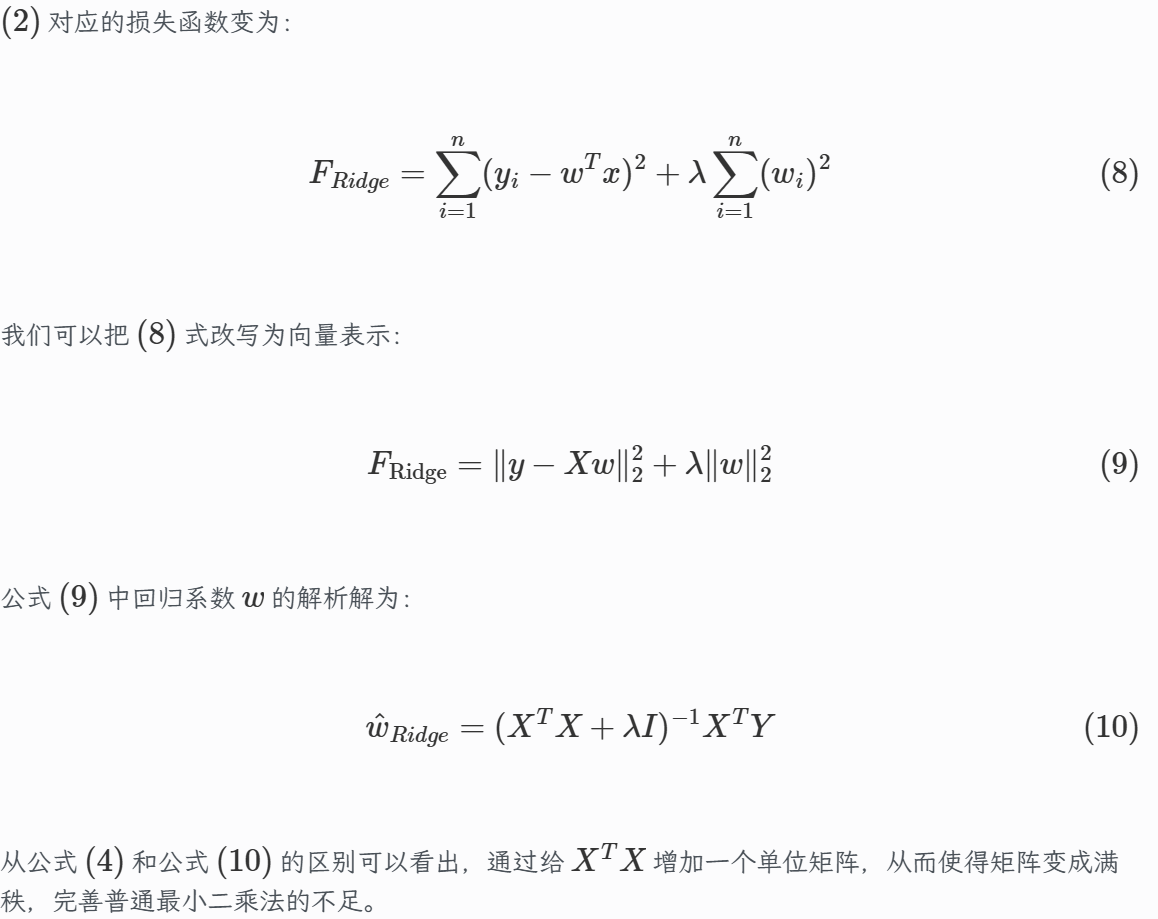



## 岭回归拟合
接下来，我们通过 scikit-learn 提供的岭回归方法 Ridge() 完成对前面示例的数据拟合。
```python
sklearn.linear_model.Ridge(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=None)
```
alpha: 正则化强度，默认为 1.0，对应公式 8 中的$\lambda$。

fit_intercept: 默认为 True，计算截距项。

normalize: 默认为 False，不针对数据进行标准化处理。

copy_X: 默认为 True，即使用数据的副本进行操作，防止影响原数据。

max_iter: 最大迭代次数，默认为 None。

tol: 数据解算精度。

solver: 根据数据类型自动选择求解器。

random_state: 随机数发生器。

https://aibydoing.com/notebooks/chapter01-06-lab-implementation-of-ridge-regression-and-lasso-regression